In [94]:
import pandas as pd

traindata = pd.read_csv('files/csv/traindata.csv')
X = traindata[['lat', 'lng']]
Y = traindata['price_per_m2']

In [95]:
import random

def get_lat(lat):
    return lat + random.uniform(-0.000406*5, 0.000406*5)

def get_lng(lng):
    return lng + random.uniform(-0.000306*5, 0.000306*5)

traindata_unique = traindata.groupby(['lat', 'lng']).quantile(q=0.5).reset_index()
traindata_dup = pd.concat([traindata_unique] * 100, ignore_index=True)
X = traindata_dup[['lat', 'lng']]
X['lat'] = X['lat'].apply(get_lat)
X['lng'] = X['lng'].apply(get_lng)
Y = traindata_dup['price_per_m2']

/tmp/ipykernel_28637/3716971717.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat'] = X['lat'].apply(get_lat)
/tmp/ipykernel_28637/3716971717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lng'] = X['lng'].apply(get_lng)


In [96]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=2)

In [97]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)

In [98]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
Y_train_scaled = Y_train/1e4

In [99]:
poly = PolynomialFeatures(degree=3).fit(X_train_scaled)
X_train_scaled = poly.transform(X_train_scaled)
X_val_scaled = poly.transform(X_val_scaled)

In [100]:
from xgboost import XGBRegressor

# Initialize the model with appropriate hyperparameters
model = XGBRegressor(
    n_estimators=200,  # Number of boosting rounds (trees)
    max_depth=6,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate (step size for updates)
    objective='reg:squarederror'  # Specify the loss function (MSE)
)

model.fit(X_train_scaled, Y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [101]:
Y_pred = model.predict(X_val_scaled) * 1e4
val_stats = Y_pred - Y_val

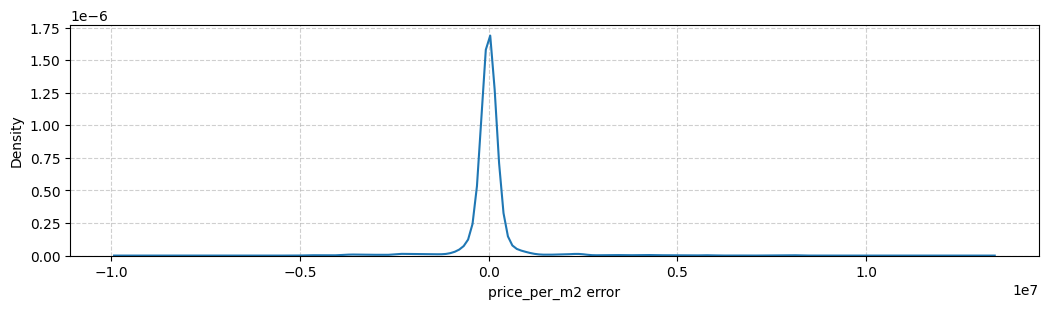

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1, figsize=(12.5,3))
sns.kdeplot(ax=ax, data=val_stats.reset_index(drop=True).sort_values())

plt.xlabel("price_per_m2 error")
plt.ylabel("Density")
plt.grid(True, alpha=0.6, linestyle="--")
plt.show()

In [109]:
Y_pred = model.predict(X_val_scaled[1398].reshape(1,10)) * 1e4
"{:,}".format(int(Y_pred[0])).replace(",", "."), "{:,}".format(int(Y_val[1398])).replace(",", ".")

('172.539', '52.238')

In [110]:
Y_pred = model.predict(X_val_scaled) * 1e4